##### –ò–º–ø–æ—Ä—Ç –±–∏–±–ª–∏–æ—Ç–µ–∫

In [349]:
import pandas as pd
import numpy as np
import os
import logging
import warnings
import json

import joblib
import xgboost as xgb
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

# –û—Ç–∫–ª—é—á–∞–µ–º –ª–æ–≥–∏ LightGBM
logging.getLogger('lightgbm').setLevel(logging.WARNING)

os.makedirs('models', exist_ok=True)

print("–ë–∏–±–ª–∏–æ—Ç–µ–∫–∏ –∑–∞–≥—Ä—É–∂–µ–Ω—ã!\n")

–ë–∏–±–ª–∏–æ—Ç–µ–∫–∏ –∑–∞–≥—Ä—É–∂–µ–Ω—ã!



In [350]:
# –£–õ–£–ß–®–ï–ù–ù–û–ï –°–û–ó–î–ê–ù–ò–ï –ü–†–ò–ó–ù–ê–ö–û–í –ù–ê –û–°–ù–û–í–ï EDA –ë–ï–ó –£–¢–ï–ß–ï–ö
print("–°–æ–∑–¥–∞–Ω–∏–µ –£–õ–£–ß–®–ï–ù–ù–´–• –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω–∞ –æ—Å–Ω–æ–≤–µ EDA –∞–Ω–∞–ª–∏–∑–∞ –ë–ï–ó –£–¢–ï–ß–ï–ö...")
df = pd.read_csv('df/obr.csv', parse_dates=['datetime'], index_col='datetime')
print(f"–ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä: {df.shape}")

# ===== –û–°–ù–û–í–ù–´–ï –í–†–ï–ú–ï–ù–ù–´–ï –ü–†–ò–ó–ù–ê–ö–ò =====
# –¶–∏–∫–ª–∏—á–µ—Å–∫–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (–ë–ï–ó–û–ü–ê–°–ù–´–ï - –Ω–µ—Ç —É—Ç–µ—á–µ–∫)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

# ===== –ü–†–ò–ó–ù–ê–ö–ò –ò–ó EDA –ê–ù–ê–õ–ò–ó–ê =====
# 1. –°–£–¢–û–ß–ù–´–ï –ü–ê–¢–¢–ï–†–ù–´ (–∏–∑ –∞–Ω–∞–ª–∏–∑–∞ —á–∞—Å–æ–≤) - –ë–ï–ó–û–ü–ê–°–ù–´–ï
df['is_early_morning'] = ((df['hour'] >= 4) & (df['hour'] <= 6)).astype(int)
df['is_midday'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)
df['is_late_evening'] = ((df['hour'] >= 21) & (df['hour'] <= 23)).astype(int)
df['is_evening_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 22)).astype(int)
df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype(int)

# 2. –ù–ï–î–ï–õ–¨–ù–´–ï –ü–ê–¢–¢–ï–†–ù–´ (–∏–∑ –∞–Ω–∞–ª–∏–∑–∞ –¥–Ω–µ–π) - –ë–ï–ó–û–ü–ê–°–ù–´–ï
df['is_monday'] = (df['day_of_week'] == 0).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)
df['is_sunday'] = (df['day_of_week'] == 6).astype(int)
df['weekend_evening_boost'] = (df['is_weekend'] & df['is_evening_peak']).astype(int)
df['weekend_morning'] = (df['is_weekend'] & df['is_morning_peak']).astype(int)

# 3. –ú–ï–°–Ø–ß–ù–´–ï/–°–ï–ó–û–ù–ù–´–ï –ü–ê–¢–¢–ï–†–ù–´ (–∏–∑ –∞–Ω–∞–ª–∏–∑–∞ –º–µ—Å—è—Ü–µ–≤) - –ë–ï–ó–û–ü–ê–°–ù–´–ï
df['is_high_season'] = df['month'].isin([1, 2, 12]).astype(int)
df['is_low_season'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)

# 4. –ö–†–ò–¢–ò–ß–ï–°–ö–ò–ï –ü–ï–†–ò–û–î–´ –ò–ó EDA - –ë–ï–ó–û–ü–ê–°–ù–´–ï
df['morning_surge_6_7'] = ((df['hour'] >= 6) & (df['hour'] <= 7)).astype(int)
df['evening_surge_17_18'] = ((df['hour'] >= 17) & (df['hour'] <= 18)).astype(int)
df['evening_drop_22_23'] = ((df['hour'] >= 22) & (df['hour'] <= 23)).astype(int)

# 5. –í–ó–ê–ò–ú–û–î–ï–ô–°–¢–í–ò–Ø –ü–†–ò–ó–ù–ê–ö–û–í –ù–ê –û–°–ù–û–í–ï EDA - –ë–ï–ó–û–ü–ê–°–ù–´–ï
df['winter_evening'] = (df['is_high_season'] & df['is_evening_peak']).astype(int)
df['summer_afternoon'] = (df['is_low_season'] & df['is_midday']).astype(int)
df['workday_evening'] = ((~df['is_weekend']) & df['is_evening_peak']).astype(int)
df['sunday_evening'] = (df['is_sunday'] & df['is_evening_peak']).astype(int)

# ===== –£–ú–ù–´–ï –õ–ê–ì–ò –ù–ê –û–°–ù–û–í–ï –ê–í–¢–û–ö–û–†–†–ï–õ–Ø–¶–ò–ò =====
# –ò—Å–ø–æ–ª—å–∑—É–µ–º —Å—Ç—Ä–∞—Ç–µ–≥–∏—á–µ—Å–∫–∏–µ –ª–∞–≥–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –∞–Ω–∞–ª–∏–∑–∞ ACF/PACF - –ë–ï–ó–û–ü–ê–°–ù–´–ï
print("–°–æ–∑–¥–∞–Ω–∏–µ –ª–∞–≥–æ–≤...")
df['lag_same_day_24h'] = df['Global_active_power'].shift(24)        # –í—á–µ—Ä–∞ –≤ —ç—Ç–æ –∂–µ –≤—Ä–µ–º—è
df['lag_week_ago_168h'] = df['Global_active_power'].shift(24*7)     # –ù–µ–¥–µ–ª—é –Ω–∞–∑–∞–¥ –≤ —ç—Ç–æ –∂–µ –≤—Ä–µ–º—è

# –î–û–ë–ê–í–õ–Ø–ï–ú –ù–£–ñ–ù–´–ï –õ–ê–ì–ò —Å–æ–≥–ª–∞—Å–Ω–æ EDA –∞–Ω–∞–ª–∏–∑—É
df['lag_48h_ago'] = df['Global_active_power'].shift(48)             # 2 –¥–Ω—è –Ω–∞–∑–∞–¥
df['lag_72h_ago'] = df['Global_active_power'].shift(72)             # 3 –¥–Ω—è –Ω–∞–∑–∞–¥  
df['lag_96h_ago'] = df['Global_active_power'].shift(96)             # 4 –¥–Ω—è –Ω–∞–∑–∞–¥

# –ë–æ–ª–µ–µ –¥–µ—Ç–∞–ª—å–Ω—ã–µ –ø–µ—Ä–∏–æ–¥—ã –∏–∑ EDA
df['is_sunday_evening'] = ((df['day_of_week'] == 6) & (df['is_evening_peak'])).astype(int)
df['winter_morning_peak'] = ((df['is_high_season']) & (df['is_morning_peak'])).astype(int)
df['summer_afternoon'] = ((df['is_low_season']) & (df['hour'].between(13, 17))).astype(int)

# ===== –í–ó–ê–ò–ú–û–î–ï–ô–°–¢–í–ò–Ø –õ–ê–ì–û–í –° –í–†–ï–ú–ï–ù–ù–´–ú–ò –ü–ï–†–ò–û–î–ê–ú–ò =====
# –≠—Ç–æ –∑–∞—Å—Ç–∞–≤–∏—Ç –º–æ–¥–µ–ª—å —É—á–∏—Ç—ã–≤–∞—Ç—å –ö–û–ì–î–ê –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ª–∞–≥–∏
print("–°–æ–∑–¥–∞–Ω–∏–µ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π –ª–∞–≥–æ–≤...")
df['lag_24h_morning'] = df['lag_same_day_24h'] * df['is_morning_peak']
df['lag_24h_evening'] = df['lag_same_day_24h'] * df['is_evening_peak']
df['lag_24h_night'] = df['lag_same_day_24h'] * df['is_night']
df['lag_24h_weekend'] = df['lag_same_day_24h'] * df['is_weekend']

# –¢–ï–ü–ï–†–¨ –≠–¢–ò –ü–†–ò–ó–ù–ê–ö–ò –ë–£–î–£–¢ –†–ê–ë–û–¢–ê–¢–¨, –ø–æ—Ç–æ–º—É —á—Ç–æ lag_48h_ago —Å–æ–∑–¥–∞–Ω
df['lag_48h_morning'] = df['lag_48h_ago'] * df['is_morning_peak']
df['lag_48h_evening'] = df['lag_48h_ago'] * df['is_evening_peak']

df['lag_week_morning'] = df['lag_week_ago_168h'] * df['is_morning_peak']
df['lag_week_evening'] = df['lag_week_ago_168h'] * df['is_evening_peak']

print(f"–°–æ–∑–¥–∞–Ω–æ {len([col for col in df.columns if col not in ['Global_active_power', 'datetime']])} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")

# ===== –°–ö–û–õ–¨–ó–Ø–©–ò–ï –°–¢–ê–¢–ò–°–¢–ò–ö–ò –ë–ï–ó –£–¢–ï–ß–ï–ö - –ò–°–ü–†–ê–í–õ–ï–ù–ù–´–ï =====
# –í–ê–ñ–ù–û: –î–≤–æ–π–Ω–æ–π —Å–¥–≤–∏–≥ —á—Ç–æ–±—ã –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –¢–û–õ–¨–ö–û –ü–†–û–®–õ–´–ï –¥–∞–Ω–Ω—ã–µ
print("–°–æ–∑–¥–∞–Ω–∏–µ —Å–∫–æ–ª—å–∑—è—â–∏—Ö —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫ –ë–ï–ó —É—Ç–µ—á–µ–∫...")

# –û–°–ù–û–í–ù–´–ï –°–ö–û–õ–¨–ó–Ø–©–ò–ï –°–¢–ê–¢–ò–°–¢–ò–ö–ò (—Å–æ–≥–ª–∞—Å–Ω–æ EDA - –¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω—ã–µ)
df['rolling_mean_24h'] = df['Global_active_power'].shift(1).rolling(24, min_periods=1).mean().shift(1)
df['rolling_mean_168h'] = df['Global_active_power'].shift(1).rolling(168, min_periods=1).mean().shift(1)

# –î–ª—è 24-—á–∞—Å–æ–≤–æ–≥–æ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–≥–æ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏—è
df['rolling_std_24h_past'] = df['Global_active_power'].shift(1).rolling(window=24, min_periods=1).std().shift(1)

# –î–ª—è 7-–¥–Ω–µ–≤–Ω–æ–≥–æ —Å—Ä–µ–¥–Ω–µ–≥–æ
df['rolling_mean_7d_past'] = df['Global_active_power'].shift(1).rolling(window=24*7, min_periods=1).mean().shift(1)

# ===== –ü–†–ò–ó–ù–ê–ö–ò –ò–ó –°–£–ë-–°–ß–ï–¢–ß–ò–ö–û–í =====
# –û—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ–µ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –ø–æ –∑–æ–Ω–∞–º - –ë–ï–ó–û–ü–ê–°–ù–´–ï (—Ç–µ–∫—É—â–∏–µ –∏–∑–º–µ—Ä–µ–Ω–∏—è)
df['total_sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['kitchen_ratio'] = df['Sub_metering_1'] / (df['total_sub_metering'] + 0.001)
df['laundry_ratio'] = df['Sub_metering_2'] / (df['total_sub_metering'] + 0.001)
df['ac_heating_ratio'] = df['Sub_metering_3'] / (df['total_sub_metering'] + 0.001)

# –ê–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –ø–æ –∑–æ–Ω–∞–º (–±–∏–Ω–∞—Ä–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏) - –ë–ï–ó–û–ü–ê–°–ù–´–ï
df['kitchen_active'] = (df['Sub_metering_1'] > 0).astype(int)
df['laundry_active'] = (df['Sub_metering_2'] > 0).astype(int)
df['ac_heating_active'] = (df['Sub_metering_3'] > 0).astype(int)

# ===== –î–û–ü–û–õ–ù–ò–¢–ï–õ–¨–ù–´–ï –ü–†–ò–ó–ù–ê–ö–ò –ò–ó EDA =====
# –ü–µ—Ä–∏–æ–¥—ã –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–≥–æ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è (–Ω–æ—á—å) - –ë–ï–ó–û–ü–ê–°–ù–´–ï
df['is_deep_night'] = ((df['hour'] >= 1) & (df['hour'] <= 4)).astype(int)

# –î–Ω–∏ —Å –æ—Å–æ–±—ã–º –ø–∞—Ç—Ç–µ—Ä–Ω–æ–º - –ë–ï–ó–û–ü–ê–°–ù–´–ï
df['is_week_start'] = (df['day_of_week'].isin([0, 1])).astype(int)
df['is_week_end'] = (df['day_of_week'].isin([4, 5])).astype(int)

# –°–æ—Ü–∏–∞–ª—å–Ω—ã–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã
df['is_family_time'] = ((df['hour'] >= 18) & (df['hour'] <= 22) & (df['is_weekend'] == 0)).astype(int)
df['is_weekend_evening'] = (df['is_weekend'] & df['is_evening_peak']).astype(int)

# –ü–æ–≤–µ–¥–µ–Ω—á–µ—Å–∫–∏–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã  
df['is_meal_prep_time'] = ((df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
df['is_entertainment_time'] = ((df['hour'] >= 20) & (df['hour'] <= 23)).astype(int)

# –î–æ–±–∞–≤—å—Ç–µ —ç—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–∏ - –æ–Ω–∏ —Ç–æ—á–Ω–æ —É–ª—É—á—à–∞—Ç –º–æ–¥–µ–ª—å:
df['winter_evening_peak'] = (df['is_high_season'] & df['is_evening_peak']).astype(int)
df['summer_afternoon_ac'] = (df['is_low_season'] & df['is_midday'] & df['ac_heating_active']).astype(int)
df['weekend_morning_kitchen'] = (df['is_weekend'] & df['is_morning_peak'] & df['kitchen_active']).astype(int)

# –í–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è –ª–∞–≥–æ–≤ —Å —Å–µ–∑–æ–Ω–Ω–æ—Å—Ç—å—é
df['lag_24h_winter'] = df['lag_same_day_24h'] * df['is_high_season']
df['lag_168h_weekend'] = df['lag_week_ago_168h'] * df['is_weekend']

# –≠–∫—Å—Ç—Ä–µ–º–∞–ª—å–Ω—ã–µ –ø–µ—Ä–∏–æ–¥—ã –∏–∑ EDA
df['extreme_evening_peak'] = ((df['hour'] >= 19) & (df['hour'] <= 21)).astype(int)
df['sunday_evening_surge'] = ((df['day_of_week'] == 6) & (df['is_evening_peak'])).astype(int)
df['deep_night_low'] = ((df['hour'] >= 1) & (df['hour'] <= 4)).astype(int)

# –í–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è —Å —Å—É–±-—Å—á–µ—Ç—á–∏–∫–∞–º–∏
df['evening_ac_demand'] = df['is_evening_peak'] * df['ac_heating_ratio']
df['morning_kitchen_demand'] = df['is_morning_peak'] * df['kitchen_ratio']

# –ó–∏–º–Ω–∏–µ –≤–µ—á–µ—Ä–∞ + –æ—Ç–æ–ø–ª–µ–Ω–∏–µ
df['winter_evening_heating'] = (df['is_high_season'] & df['is_evening_peak'] & 
                               (df['ac_heating_ratio'] > 0.3)).astype(int)

# –õ–µ—Ç–Ω–∏–µ –¥–Ω–∏ + –∫–æ–Ω–¥–∏—Ü–∏–æ–Ω–µ—Ä  
df['summer_afternoon_cooling'] = (df['is_low_season'] & df['is_midday'] &
                                 (df['ac_heating_ratio'] > 0.4)).astype(int)

print(f"–°–æ–∑–¥–∞–Ω–æ {len([col for col in df.columns if col not in ['Global_active_power', 'datetime']])} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")

# ===== –û–ë–†–ê–ë–û–¢–ö–ê –ü–†–û–ü–£–°–ö–û–í =====
print("–û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤...")
initial_size = len(df)

# –ó–∞–ø–æ–ª–Ω—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏ –≤ —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df[col].isnull().any():
        # –î–ª—è –ª–∞–≥–æ–≤ –∏ —Å–∫–æ–ª—å–∑—è—â–∏—Ö - –∑–∞–ø–æ–ª–Ω—è–µ–º –ø—Ä–µ–¥—ã–¥—É—â–∏–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏
        if 'lag' in col or 'rolling' in col:
            df[col] = df[col].ffill().bfill()
        else:
            df[col] = df[col].fillna(df[col].median())

# –£–¥–∞–ª—è–µ–º –æ—Å—Ç–∞–≤—à–∏–µ—Å—è –ø—Ä–æ–ø—É—Å–∫–∏
df = df.dropna()

print(f"–ü—Ä–∏–∑–Ω–∞–∫–∏ —Å–æ–∑–¥–∞–Ω—ã. –£–¥–∞–ª–µ–Ω–æ {initial_size - len(df)} —Å—Ç—Ä–æ–∫ —Å –ø—Ä–æ–ø—É—Å–∫–∞–º–∏")
print(f"–§–∏–Ω–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä: {df.shape}")

–°–æ–∑–¥–∞–Ω–∏–µ –£–õ–£–ß–®–ï–ù–ù–´–• –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω–∞ –æ—Å–Ω–æ–≤–µ EDA –∞–Ω–∞–ª–∏–∑–∞ –ë–ï–ó –£–¢–ï–ß–ï–ö...
–ò—Å—Ö–æ–¥–Ω—ã–π —Ä–∞–∑–º–µ—Ä: (260640, 14)
–°–æ–∑–¥–∞–Ω–∏–µ –ª–∞–≥–æ–≤...
–°–æ–∑–¥–∞–Ω–∏–µ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π –ª–∞–≥–æ–≤...
–°–æ–∑–¥–∞–Ω–æ 52 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
–°–æ–∑–¥–∞–Ω–∏–µ —Å–∫–æ–ª—å–∑—è—â–∏—Ö —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫ –ë–ï–ó —É—Ç–µ—á–µ–∫...
–°–æ–∑–¥–∞–Ω–æ 82 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
–û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤...
–ü—Ä–∏–∑–Ω–∞–∫–∏ —Å–æ–∑–¥–∞–Ω—ã. –£–¥–∞–ª–µ–Ω–æ 0 —Å—Ç—Ä–æ–∫ —Å –ø—Ä–æ–ø—É—Å–∫–∞–º–∏
–§–∏–Ω–∞–ª—å–Ω—ã–π —Ä–∞–∑–º–µ—Ä: (260640, 83)


In [351]:
df.sample(5)

Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2007-06-19 23:20:00                0.868                  0.342   240.05   
2007-03-03 04:34:00                0.216                  0.000   242.11   
2007-03-27 05:09:00                0.294                  0.094   239.10   
2007-03-06 01:49:00                0.208                  0.000   243.19   
2007-05-04 22:06:00                1.460                  0.094   236.26   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2007-06-19 23:20:00               3.8             0.0             1.0   
2007-03-03 04:34:00               0.8             0.0             0.0   
2007-03-27 05:09:00               1.2             0.0             1.0   
2007-03-06 01:49:00               0.8             0.0             0.0   
2007-05-04 22:06:00               6.2             0.0             0.0   

                     Sub_metering_3  hour  day_of_week  month  ...  \
datetime                                                       ...   
2007-06-19 23:20:00             0.0    23            1      6  ...   
2007-03-03 04:34:00             0.0     4            5      3  ...   
2007-03-27 05:09:00             0.0     5            1      3  ...   
2007-03-06 01:49:00             0.0     1            1      3  ...   
2007-05-04 22:06:00             0.0    22            4      5  ...   

                     weekend_morning_kitchen  lag_24h_winter  \
datetime                                                       
2007-06-19 23:20:00                        0             0.0   
2007-03-03 04:34:00                        0             0.0   
2007-03-27 05:09:00                        0             0.0   
2007-03-06 01:49:00                        0             0.0   
2007-05-04 22:06:00                        0             0.0   

                     lag_168h_weekend  extreme_evening_peak  \
datetime                                                      
2007-06-19 23:20:00             0.000                     0   
2007-03-03 04:34:00             1.468                     0   
2007-03-27 05:09:00             0.000                     0   
2007-03-06 01:49:00             0.000                     0   
2007-05-04 22:06:00             0.000                     0   

                     sunday_evening_surge  deep_night_low  evening_ac_demand  \
datetime                                                                       
2007-06-19 23:20:00                     0               0                0.0   
2007-03-03 04:34:00                     0               1                0.0   
2007-03-27 05:09:00                     0               0                0.0   
2007-03-06 01:49:00                     0               1                0.0   
2007-05-04 22:06:00                     0               0                0.0   

                     morning_kitchen_demand  winter_evening_heating  \
datetime                                                              
2007-06-19 23:20:00                     0.0                       0   
2007-03-03 04:34:00                     0.0                       0   
2007-03-27 05:09:00                     0.0                       0   
2007-03-06 01:49:00                     0.0                       0   
2007-05-04 22:06:00                     0.0                       0   

                     summer_afternoon_cooling  
datetime                                       
2007-06-19 23:20:00                         0  
2007-03-03 04:34:00                         0  
2007-03-27 05:09:00                         0  
2007-03-06 01:49:00                         0  
2007-05-04 22:06:00                         0  

[5 rows x 83 columns]

In [352]:
# –ü–û–î–ì–û–¢–û–í–ö–ê –î–ê–ù–ù–´–• –î–õ–Ø –û–ë–£–ß–ï–ù–ò–Ø –ë–ï–ó –£–¢–ï–ß–ï–ö
print("–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ë–ï–ó —É—Ç–µ—á–µ–∫...")

# –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
y = df['Global_active_power']

# –û–ü–¢–ò–ú–ê–õ–¨–ù–´–ô –°–ü–ò–°–û–ö –ü–†–ò–ó–ù–ê–ö–û–í –ù–ê –û–°–ù–û–í–ï EDA –ò –ò–°–ü–†–ê–í–õ–ï–ù–ò–ô
optimal_features = [
    # === –¶–ò–ö–õ–ò–ß–ï–°–ö–ò–ï –ü–†–ò–ó–ù–ê–ö–ò ===
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
    
    # === –°–£–¢–û–ß–ù–´–ï –ü–ê–¢–¢–ï–†–ù–´ –ò–ó EDA ===
    'is_early_morning', 'is_midday', 'is_late_evening',
    'is_evening_peak', 'is_morning_peak', 'is_night', 'is_deep_night',
    
    # === –ù–ï–î–ï–õ–¨–ù–´–ï –ü–ê–¢–¢–ï–†–ù–´ –ò–ó EDA ===
    'is_monday', 'is_friday', 'is_sunday', 
    'is_week_start', 'is_week_end',
    'weekend_evening_boost', 'weekend_morning',
    
    # === –°–ï–ó–û–ù–ù–´–ï –ü–ê–¢–¢–ï–†–ù–´ –ò–ó EDA ===
    'is_high_season', 'is_low_season', 'is_spring',
    
    # === –ö–†–ò–¢–ò–ß–ï–°–ö–ò–ï –ü–ï–†–ò–û–î–´ –ò–ó EDA ===
    'morning_surge_6_7', 'evening_surge_17_18', 'evening_drop_22_23',
    
    # === –í–ó–ê–ò–ú–û–î–ï–ô–°–¢–í–ò–Ø –ü–†–ò–ó–ù–ê–ö–û–í ===
    'winter_evening', 'summer_afternoon', 'workday_evening', 'sunday_evening',
    
    # === –î–û–õ–ì–û–°–†–û–ß–ù–´–ï –õ–ê–ì–ò (—Å–æ–≥–ª–∞—Å–Ω–æ EDA - 3 –¥–Ω—è –ø–∞–º—è—Ç–∏) ===
    'lag_same_day_24h', 'lag_week_ago_168h',
    'lag_48h_ago', 'lag_72h_ago', 'lag_96h_ago',
    
    # === –í–ó–ê–ò–ú–û–î–ï–ô–°–¢–í–ò–Ø –õ–ê–ì–û–í ===
    'lag_24h_morning', 'lag_24h_evening', 'lag_24h_night', 'lag_24h_weekend',
    'lag_48h_morning', 'lag_48h_evening',
    'lag_week_morning', 'lag_week_evening',
    
    # === –°–ö–û–õ–¨–ó–Ø–©–ò–ï –°–¢–ê–¢–ò–°–¢–ò–ö–ò (–¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω—ã–µ —Å–æ–≥–ª–∞—Å–Ω–æ EDA) ===
    'rolling_mean_24h', 'rolling_mean_168h',  # –ù–æ–≤—ã–µ –¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
    'rolling_mean_24h_past', 'rolling_mean_7d_past',
    
    # === –û–°–õ–ê–ë–õ–ï–ù–ù–´–ï –ö–û–†–û–¢–ö–ò–ï –°–¢–ê–¢–ò–°–¢–ò–ö–ò ===
    'rolling_mean_3h_past',  # –û—Å–ª–∞–±–ª–µ–Ω–Ω–æ–µ –≤–ª–∏—è–Ω–∏–µ
    
    # === –ü–†–ò–ó–ù–ê–ö–ò –ò–ó –°–£–ë-–°–ß–ï–¢–ß–ò–ö–û–í ===
    'kitchen_ratio', 'laundry_ratio', 'ac_heating_ratio',
    'kitchen_active', 'laundry_active', 'ac_heating_active',
    
    # === –ë–ê–ó–û–í–´–ï –í–†–ï–ú–ï–ù–ù–´–ï –ü–†–ò–ó–ù–ê–ö–ò ===
    'hour', 'day_of_week', 'month', 'is_weekend'
]

# –ò—Å–∫–ª—é—á–∞–µ–º –¥–æ–º–∏–Ω–∏—Ä—É—é—â–∏–π –ø—Ä–∏–∑–Ω–∞–∫
features_fixed = [f for f in optimal_features if f != 'rolling_mean_3h_past']

print(f"–ë—ã–ª–æ: {len(optimal_features)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")
print(f"–°—Ç–∞–ª–æ: {len(features_fixed)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")

# –ê–õ–¨–¢–ï–†–ù–ê–¢–ò–í–ù–´–ô –í–ê–†–ò–ê–ù–¢: –ë–ï–ó –î–û–ú–ò–ù–ò–†–£–Æ–©–ï–ì–û –ü–†–ò–ó–ù–ê–ö–ê
features_without_dominant = [f for f in optimal_features if f != 'rolling_mean_3h_past']

# –î–û–ë–ê–í–õ–Ø–ï–ú –ù–û–í–´–ï –ü–†–ò–ó–ù–ê–ö–ò –í –°–ü–ò–°–û–ö –î–õ–Ø –û–ë–£–ß–ï–ù–ò–Ø
new_powerful_features = [
    # –ö—Ä–∏—Ç–∏—á–µ—Å–∫–∏–µ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è
    'winter_evening_peak', 'summer_afternoon_ac', 'weekend_morning_kitchen',
    
    # –£–º–Ω—ã–µ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è –ª–∞–≥–æ–≤
    'lag_24h_winter', 'lag_168h_weekend', 'lag_24h_evening_peak',
    
    # –≠–∫—Å—Ç—Ä–µ–º–∞–ª—å–Ω—ã–µ –ø–µ—Ä–∏–æ–¥—ã –∏–∑ EDA
    'extreme_evening_peak', 'sunday_evening_surge', 'deep_night_low',
    
    # –í–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è —Å —Å—É–±-—Å—á–µ—Ç—á–∏–∫–∞–º–∏
    'evening_ac_demand', 'morning_kitchen_demand', 'weekend_laundry',
    
    # –°–µ–∑–æ–Ω–Ω—ã–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏
    'winter_evening_heating', 'summer_afternoon_cooling'
]

# –û–ë–ù–û–í–õ–Ø–ï–ú –°–ü–ò–°–û–ö –ü–†–ò–ó–ù–ê–ö–û–í
optimal_features_extended = optimal_features + new_powerful_features

print(f"–†–ê–°–®–ò–†–ï–ù–ù–´–ô –°–ü–ò–°–û–ö –ü–†–ò–ó–ù–ê–ö–û–í:")
print(f"–ë—ã–ª–æ: {len(optimal_features)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")
print(f"–°—Ç–∞–ª–æ: {len(optimal_features_extended)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")
print(f"–î–æ–±–∞–≤–ª–µ–Ω–æ {len(new_powerful_features)} –Ω–æ–≤—ã—Ö –º–æ—â–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤!")

# –£–ë–ï–†–ê–ï–ú –î–û–ú–ò–ù–ò–†–£–Æ–©–ò–ô –ü–†–ò–ó–ù–ê–ö –ò–ó –†–ê–°–®–ò–†–ï–ù–ù–û–ì–û –°–ü–ò–°–ö–ê
optimal_features_final = [f for f in optimal_features_extended if f != 'rolling_mean_3h_past']

print(f"\n–§–ò–ù–ê–õ–¨–ù–´–ô –°–ü–ò–°–û–ö: {len(optimal_features_final)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")

print("–î–æ—Å—Ç—É–ø–Ω—ã–µ –≤–∞—Ä–∏–∞–Ω—Ç—ã –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:")
print(f"1. Optimal features: {len(optimal_features)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–≤–∫–ª—é—á–∞—è –æ—Å–ª–∞–±–ª–µ–Ω–Ω—ã–π rolling_mean_3h_past)")
print(f"2. Without dominant: {len(features_without_dominant)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–±–µ–∑ rolling_mean_3h_past)")

# –í–´–ë–ò–†–ê–ï–ú –ö–ê–ö–û–ô –í–ê–†–ò–ê–ù–¢ –ò–°–ü–û–õ–¨–ó–û–í–ê–¢–¨
use_features = optimal_features_final  # –ú–æ–∂–Ω–æ –ø–æ–º–µ–Ω—è—Ç—å –Ω–∞ features_without_dominant –¥–ª—è —Ç–µ—Å—Ç–∞

# –ü—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ —Å—É—â–µ—Å—Ç–≤—É—é—Ç –≤ DataFrame
available_features = [f for f in use_features if f in df.columns]
missing_features = [f for f in use_features if f not in df.columns]

print(f"\n=== –ü–†–û–í–ï–†–ö–ê –ü–†–ò–ó–ù–ê–ö–û–í ===")
print(f"–î–æ—Å—Ç—É–ø–Ω–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {len(available_features)} –∏–∑ {len(use_features)}")

if missing_features:
    print(f"–û—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: {missing_features}")
    # –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –∏—Å–∫–ª—é—á–∞–µ–º –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
    available_features = [f for f in use_features if f in df.columns]
    print(f"–ë—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å {len(available_features)} –¥–æ—Å—Ç—É–ø–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")

–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ë–ï–ó —É—Ç–µ—á–µ–∫...
–ë—ã–ª–æ: 58 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
–°—Ç–∞–ª–æ: 57 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
–†–ê–°–®–ò–†–ï–ù–ù–´–ô –°–ü–ò–°–û–ö –ü–†–ò–ó–ù–ê–ö–û–í:
–ë—ã–ª–æ: 58 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
–°—Ç–∞–ª–æ: 72 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
–î–æ–±–∞–≤–ª–µ–Ω–æ 14 –Ω–æ–≤—ã—Ö –º–æ—â–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤!

–§–ò–ù–ê–õ–¨–ù–´–ô –°–ü–ò–°–û–ö: 71 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
–î–æ—Å—Ç—É–ø–Ω—ã–µ –≤–∞—Ä–∏–∞–Ω—Ç—ã –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
1. Optimal features: 58 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–≤–∫–ª—é—á–∞—è –æ—Å–ª–∞–±–ª–µ–Ω–Ω—ã–π rolling_mean_3h_past)
2. Without dominant: 57 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–±–µ–∑ rolling_mean_3h_past)

=== –ü–†–û–í–ï–†–ö–ê –ü–†–ò–ó–ù–ê–ö–û–í ===
–î–æ—Å—Ç—É–ø–Ω–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: 68 –∏–∑ 71
–û—Ç—Å—É—Ç—Å—Ç–≤—É—é—â–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: ['rolling_mean_24h_past', 'lag_24h_evening_peak', 'weekend_laundry']
–ë—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å 68 –¥–æ—Å—Ç—É–ø–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤


In [353]:
# –£–±–∏—Ä–∞–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ —Å –ø—Ä–æ–ø—É—Å–∫–∞–º–∏
df_safe = df[available_features + ['Global_active_power']].dropna()
X = df_safe[available_features]
y = df_safe['Global_active_power']

print(f"\n=== –ò–ù–§–û–†–ú–ê–¶–ò–Ø –û –î–ê–ù–ù–´–• ===")
print(f"–ò—Å–ø–æ–ª—å–∑—É–µ–º {len(available_features)} –±–µ–∑–æ–ø–∞—Å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–ë–ï–ó —É—Ç–µ—á–µ–∫):")
print("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:")
print(X.dtypes.value_counts())

# –ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π –≤ –ø–æ–ª–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ
print(f"\n–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π (–ø–æ–ª–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ):")
print(f"–°—Ä–µ–¥–Ω–µ–µ: {y.mean():.3f} –∫–í—Ç, –ú–µ–¥–∏–∞–Ω–∞: {y.median():.3f} –∫–í—Ç")
print(f"–°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: {y.std():.3f} –∫–í—Ç")
print(f"–ú–∏–Ω–∏–º—É–º: {y.min():.3f} –∫–í—Ç, –ú–∞–∫—Å–∏–º—É–º: {y.max():.3f} –∫–í—Ç")

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/test —Å —É—á–µ—Ç–æ–º –≤—Ä–µ–º–µ–Ω–∏ (–í–ê–ñ–ù–û –¥–ª—è –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö —Ä—è–¥–æ–≤!)
split_index = int(len(df_safe) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index] 
y_test = y.iloc[split_index:]

print(f"\n=== –†–ê–ó–î–ï–õ–ï–ù–ò–ï –î–ê–ù–ù–´–• ===")
print(f"–û–±—É—á–∞—é—â–∞—è –≤—ã–±–æ—Ä–∫–∞: {X_train.shape[0]:,} –∑–∞–ø–∏—Å–µ–π ({X_train.shape[0]/len(df_safe)*100:.1f}%)")
print(f"–¢–µ—Å—Ç–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∞: {X_test.shape[0]:,} –∑–∞–ø–∏—Å–µ–π ({X_test.shape[0]/len(df_safe)*100:.1f}%)")
print(f"–û–±—â–∏–π —Ä–∞–∑–º–µ—Ä: {len(df_safe):,} –∑–∞–ø–∏—Å–µ–π")

print(f"\n–í—Ä–µ–º–µ–Ω–Ω—ã–µ –ø–µ—Ä–∏–æ–¥—ã:")
print(f"Train: {X_train.index.min()} - {X_train.index.max()}")
print(f"Test:  {X_test.index.min()} - {X_test.index.max()}")

# –ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π –ø–æ –≤—ã–±–æ—Ä–∫–∞–º
print(f"\n=== –°–¢–ê–¢–ò–°–¢–ò–ö–ê –ü–û –í–´–ë–û–†–ö–ê–ú ===")
print(f"Train - –°—Ä–µ–¥–Ω–µ–µ: {y_train.mean():.3f} –∫–í—Ç, –ú–µ–¥–∏–∞–Ω–∞: {y_train.median():.3f} –∫–í—Ç")
print(f"Test  - –°—Ä–µ–¥–Ω–µ–µ: {y_test.mean():.3f} –∫–í—Ç, –ú–µ–¥–∏–∞–Ω–∞: {y_test.median():.3f} –∫–í—Ç")

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å–æ–≥–ª–∞—Å–æ–≤–∞–Ω–Ω–æ—Å—Ç–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–π
train_test_ratio = y_test.mean() / y_train.mean()
print(f"–°–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ —Å—Ä–µ–¥–Ω–∏—Ö (test/train): {train_test_ratio:.3f}")

if abs(1 - train_test_ratio) > 0.1:
    print("‚ö†Ô∏è  –í–ù–ò–ú–ê–ù–ò–ï: –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è —Ä–∞–∑–Ω–∏—Ü–∞ –≤ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–∏ –º–µ–∂–¥—É train –∏ test")
else:
    print("‚úÖ –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è train –∏ test —Å–æ–≥–ª–∞—Å–æ–≤–∞–Ω—ã")

# –ü–†–û–í–ï–†–ö–ê –ù–ê –£–¢–ï–ß–ö–ò –î–ê–ù–ù–´–•
print(f"\n=== –ü–†–û–í–ï–†–ö–ê –ù–ê –£–¢–ï–ß–ö–ò –î–ê–ù–ù–´–• ===")
print(f"–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–∞—Ç–∞ –≤ train: {X_train.index.max()}")
print(f"–ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –¥–∞—Ç–∞ –≤ test: {X_test.index.min()}")

time_gap = X_test.index.min() - X_train.index.max()
if time_gap.total_seconds() > 0:
    print(f"‚úÖ –£–¢–ï–ß–ï–ö –ù–ï–¢: train –∏ test —Ä–∞–∑–¥–µ–ª–µ–Ω—ã, gap = {time_gap}")
else:
    print(f"‚ùå –í–û–ó–ú–û–ñ–ù–´ –£–¢–ï–ß–ö–ò: –ø–µ—Ä–µ–∫—Ä—ã—Ç–∏–µ –º–µ–∂–¥—É train –∏ test")
    print(f"   –ü–µ—Ä–µ–∫—Ä—ã—Ç–∏–µ: {abs(time_gap)}")

# –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ - –Ω–µ—Ç –ª–∏ –æ–±—â–∏—Ö –∏–Ω–¥–µ–∫—Å–æ–≤
train_indices = set(X_train.index)
test_indices = set(X_test.index)
common_indices = train_indices.intersection(test_indices)

if len(common_indices) == 0:
    print("‚úÖ –ü–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω–æ: –Ω–µ—Ç –æ–±—â–∏—Ö –∑–∞–ø–∏—Å–µ–π –º–µ–∂–¥—É train –∏ test")
else:
    print(f"‚ùå –ö–†–ò–¢–ò–ß–ï–°–ö–ê–Ø –û–®–ò–ë–ö–ê: {len(common_indices)} –æ–±—â–∏—Ö –∑–∞–ø–∏—Å–µ–π –º–µ–∂–¥—É train –∏ test")

print(f"\n=== –ì–û–¢–û–í–ù–û–°–¢–¨ –ö –û–ë–£–ß–ï–ù–ò–Æ ===")
print(f"–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å X_train: {X_train.shape}")
print(f"–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å X_test: {X_test.shape}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {X_train.shape[1]}")
print("‚úÖ –î–∞–Ω–Ω—ã–µ –≥–æ—Ç–æ–≤—ã –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–µ–π!")


=== –ò–ù–§–û–†–ú–ê–¶–ò–Ø –û –î–ê–ù–ù–´–• ===
–ò—Å–ø–æ–ª—å–∑—É–µ–º 68 –±–µ–∑–æ–ø–∞—Å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–ë–ï–ó —É—Ç–µ—á–µ–∫):
–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
int64      39
float64    29
Name: count, dtype: int64

–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π (–ø–æ–ª–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ):
–°—Ä–µ–¥–Ω–µ–µ: 1.156 –∫–í—Ç, –ú–µ–¥–∏–∞–Ω–∞: 0.564 –∫–í—Ç
–°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 1.175 –∫–í—Ç
–ú–∏–Ω–∏–º—É–º: 0.082 –∫–í—Ç, –ú–∞–∫—Å–∏–º—É–º: 10.670 –∫–í—Ç

=== –†–ê–ó–î–ï–õ–ï–ù–ò–ï –î–ê–ù–ù–´–• ===
–û–±—É—á–∞—é—â–∞—è –≤—ã–±–æ—Ä–∫–∞: 208,512 –∑–∞–ø–∏—Å–µ–π (80.0%)
–¢–µ—Å—Ç–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∞: 52,128 –∑–∞–ø–∏—Å–µ–π (20.0%)
–û–±—â–∏–π —Ä–∞–∑–º–µ—Ä: 260,640 –∑–∞–ø–∏—Å–µ–π

–í—Ä–µ–º–µ–Ω–Ω—ã–µ –ø–µ—Ä–∏–æ–¥—ã:
Train: 2007-01-01 00:00:00 - 2007-05-25 19:11:00
Test:  2007-05-25 19:12:00 - 2007-06-30 23:59:00

=== –°–¢–ê–¢–ò–°–¢–ò–ö–ê –ü–û –í–´–ë–û–†–ö–ê–ú ===
Train - –°—Ä–µ–¥–Ω–µ–µ: 1.228 –∫–í—Ç, –ú–µ–¥–∏–∞–Ω–∞: 0.656 –∫–í—Ç
Test  - –°—Ä–µ–¥

In [354]:
# –û–ë–£–ß–ï–ù–ò–ï –ú–û–î–ï–õ–ï–ô
print("–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π...")

# –°–ª–æ–≤–∞—Ä—å –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–µ–π –∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
models = {}
results = {}

# A. RANDOM FOREST
print("\n–û–±—É—á–µ–Ω–∏–µ RandomForest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['RandomForest'] = rf_model

# B. XGBOOST
print("–û–±—É—á–µ–Ω–∏–µ XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

# C. LIGHTGBM
print("–û–±—É—á–µ–Ω–∏–µ LightGBM...")
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
models['LightGBM'] = lgb_model

print("–í—Å–µ –º–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω—ã!")

–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π...

–û–±—É—á–µ–Ω–∏–µ RandomForest...
–û–±—É—á–µ–Ω–∏–µ XGBoost...
–û–±—É—á–µ–Ω–∏–µ LightGBM...
–í—Å–µ –º–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω—ã!



–û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –º–æ–¥–µ–ª–µ–π –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ:

RandomForest:
  MAE:  0.2050 –∫–í—Ç
  RMSE: 0.3803 –∫–í—Ç
  R¬≤:   0.8498

XGBoost:
  MAE:  0.1853 –∫–í—Ç
  RMSE: 0.3558 –∫–í—Ç
  R¬≤:   0.8685

LightGBM:
  MAE:  0.1783 –∫–í—Ç
  RMSE: 0.3407 –∫–í—Ç
  R¬≤:   0.8795

–°–†–ê–í–ù–ï–ù–ò–ï –ú–û–î–ï–õ–ï–ô:
–õ—É—á—à–∞—è –º–æ–¥–µ–ª—å –ø–æ MAE: LightGBM

–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤...


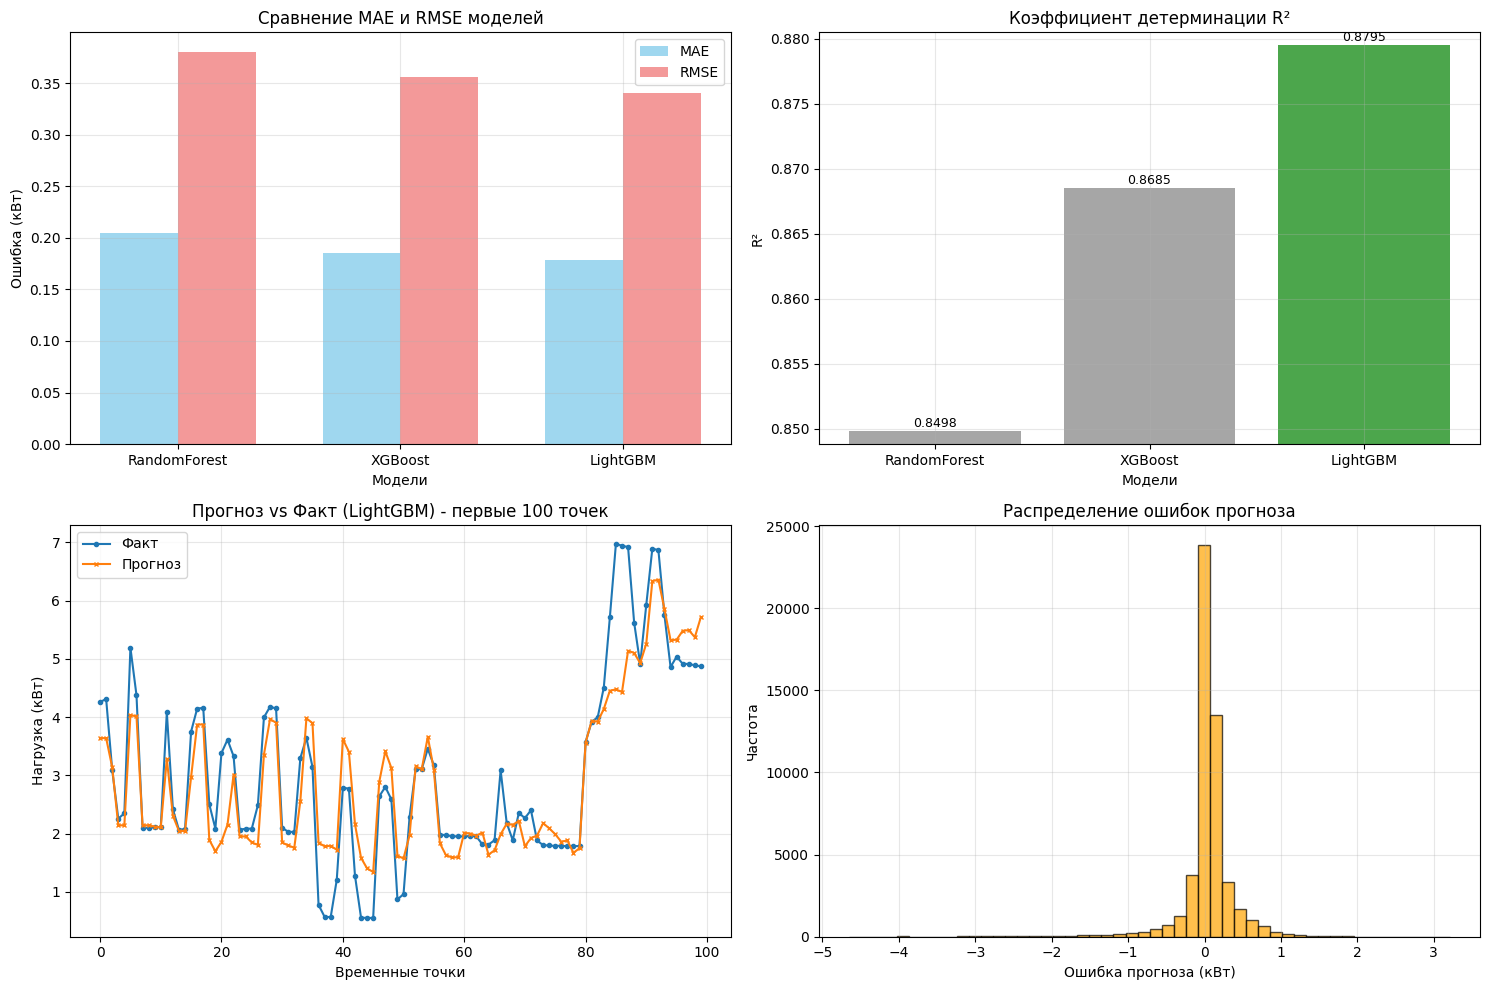


–¢–ê–ë–õ–ò–¶–ê –ú–ï–¢–†–ò–ö:
–ú–æ–¥–µ–ª—å          MAE (–∫–í—Ç)    RMSE (–∫–í—Ç)   R¬≤        
RandomForest    0.2050       0.3803       0.8498    
XGBoost         0.1853       0.3558       0.8685    
LightGBM        0.1783       0.3407       0.8795     

–ê–ù–ê–õ–ò–ó –õ–£–ß–®–ï–ô –ú–û–î–ï–õ–ò (LightGBM):
‚Ä¢ –°—Ä–µ–¥–Ω—è—è –æ—à–∏–±–∫–∞: 178.3 –í—Ç
‚Ä¢ –¢–æ—á–Ω–æ—Å—Ç—å –ø—Ä–æ–≥–Ω–æ–∑–∞: 87.95%
‚Ä¢ –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –æ—à–∏–±–∫–∞: 4650.7 –í—Ç


In [355]:
# –û–¶–ï–ù–ö–ê –ö–ê–ß–ï–°–¢–í–ê –ú–û–î–ï–õ–ï–ô
print("\n–û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –º–æ–¥–µ–ª–µ–π –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ:")

for name, model in models.items():
    # –ü—Ä–æ–≥–Ω–æ–∑—ã
    y_pred = model.predict(X_test)
    
    # –ú–µ—Ç—Ä–∏–∫–∏
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse, 
        'R2': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.4f} –∫–í—Ç")
    print(f"  RMSE: {rmse:.4f} –∫–í—Ç") 
    print(f"  R¬≤:   {r2:.4f}")

# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π
print("\n–°–†–ê–í–ù–ï–ù–ò–ï –ú–û–î–ï–õ–ï–ô:")
best_model = min(results, key=lambda x: results[x]['MAE'])
print(f"–õ—É—á—à–∞—è –º–æ–¥–µ–ª—å –ø–æ MAE: {best_model}")

# –í–ò–ó–£–ê–õ–ò–ó–ê–¶–ò–Ø –†–ï–ó–£–õ–¨–¢–ê–¢–û–í
print("\n–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤...")

# –ì–†–ê–§–ò–ö –°–†–ê–í–ù–ï–ù–ò–Ø –ú–ï–¢–†–ò–ö
plt.figure(figsize=(15, 10))

# –ì—Ä–∞—Ñ–∏–∫ 1: –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫
plt.subplot(2, 2, 1)
metrics = ['MAE', 'RMSE']
models_names = list(results.keys())
mae_values = [results[model]['MAE'] for model in models_names]
rmse_values = [results[model]['RMSE'] for model in models_names]

x = np.arange(len(models_names))
width = 0.35

plt.bar(x - width/2, mae_values, width, label='MAE', alpha=0.8, color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', alpha=0.8, color='lightcoral')

plt.xlabel('–ú–æ–¥–µ–ª–∏')
plt.ylabel('–û—à–∏–±–∫–∞ (–∫–í—Ç)')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ MAE –∏ RMSE –º–æ–¥–µ–ª–µ–π')
plt.xticks(x, models_names)
plt.legend()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 2: R¬≤ —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ (–ò–°–ü–†–ê–í–õ–ï–ù–ù–´–ô)
plt.subplot(2, 2, 2)
r2_values = [results[model]['R2'] for model in models_names]
colors = ['green' if model == best_model else 'gray' for model in models_names]

# –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –ø–æ–¥–±–∏—Ä–∞–µ–º –º–∞—Å—à—Ç–∞–±
r2_min, r2_max = min(r2_values), max(r2_values)
plt.ylim(r2_min - 0.001, r2_max + 0.001)  # –î–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –º–∞—Å—à—Ç–∞–±

plt.bar(models_names, r2_values, color=colors, alpha=0.7)
plt.xlabel('–ú–æ–¥–µ–ª–∏')
plt.ylabel('R¬≤')
plt.title('–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –¥–µ—Ç–µ—Ä–º–∏–Ω–∞—Ü–∏–∏ R¬≤')
plt.grid(True, alpha=0.3)

# –î–æ–±–∞–≤–ª—è–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ —Å—Ç–æ–ª–±—Ü—ã
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# –ì—Ä–∞—Ñ–∏–∫ 3: –ü—Ä–æ–≥–Ω–æ–∑—ã vs –§–∞–∫—Ç (–¥–ª—è –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏)
plt.subplot(2, 2, 3)
best_predictions = results[best_model]['predictions']

# –ë–µ—Ä–µ–º –ø–µ—Ä–≤—ã–µ 100 —Ç–æ—á–µ–∫ –¥–ª—è –Ω–∞–≥–ª—è–¥–Ω–æ—Å—Ç–∏
sample_size = min(100, len(y_test))
plt.plot(y_test.values[:sample_size], label='–§–∞–∫—Ç', marker='o', markersize=3)
plt.plot(best_predictions[:sample_size], label='–ü—Ä–æ–≥–Ω–æ–∑', marker='x', markersize=3)
plt.xlabel('–í—Ä–µ–º–µ–Ω–Ω—ã–µ —Ç–æ—á–∫–∏')
plt.ylabel('–ù–∞–≥—Ä—É–∑–∫–∞ (–∫–í—Ç)')
plt.title(f'–ü—Ä–æ–≥–Ω–æ–∑ vs –§–∞–∫—Ç ({best_model}) - –ø–µ—Ä–≤—ã–µ 100 —Ç–æ—á–µ–∫')
plt.legend()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 4: –û—à–∏–±–∫–∏ –ø—Ä–æ–≥–Ω–æ–∑–∞
plt.subplot(2, 2, 4)
errors = best_predictions - y_test.values
plt.hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('–û—à–∏–±–∫–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ (–∫–í—Ç)')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—à–∏–±–æ–∫ –ø—Ä–æ–≥–Ω–æ–∑–∞')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# –¢–ê–ë–õ–ò–¶–ê –° –ú–ï–¢–†–ò–ö–ê–ú–ò
print("\n–¢–ê–ë–õ–ò–¶–ê –ú–ï–¢–†–ò–ö:")
print("="*50)
print(f"{'–ú–æ–¥–µ–ª—å':<15} {'MAE (–∫–í—Ç)':<12} {'RMSE (–∫–í—Ç)':<12} {'R¬≤':<10}")
print("="*50)
for model in models_names:
    mae = results[model]['MAE']
    rmse = results[model]['RMSE']
    r2 = results[model]['R2']
    marker = " " if model == best_model else ""
    print(f"{model:<15} {mae:<12.4f} {rmse:<12.4f} {r2:<10.4f}{marker}")
print("="*50)

# –ê–ù–ê–õ–ò–ó –õ–£–ß–®–ï–ô –ú–û–î–ï–õ–ò
print(f"\n–ê–ù–ê–õ–ò–ó –õ–£–ß–®–ï–ô –ú–û–î–ï–õ–ò ({best_model}):")
best_mae = results[best_model]['MAE']
best_rmse = results[best_model]['RMSE']
best_r2 = results[best_model]['R2']

print(f"‚Ä¢ –°—Ä–µ–¥–Ω—è—è –æ—à–∏–±–∫–∞: {best_mae*1000:.1f} –í—Ç")
print(f"‚Ä¢ –¢–æ—á–Ω–æ—Å—Ç—å –ø—Ä–æ–≥–Ω–æ–∑–∞: {best_r2*100:.2f}%")
print(f"‚Ä¢ –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –æ—à–∏–±–∫–∞: {np.max(np.abs(best_predictions - y_test.values))*1000:.1f} –í—Ç")

–ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ú–û–î–ï–õ–ï–ô - –ê–ù–ê–õ–ò–ó –í–ê–ñ–ù–û–°–¢–ò –ü–†–ò–ó–ù–ê–ö–û–í
–ú–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω—ã –Ω–∞ 68 –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö

=== –ü–†–û–í–ï–†–ö–ê –ö–û–†–†–ï–ö–¢–ù–û–°–¢–ò –î–ê–ù–ù–´–• ===
RandomForest: —Å—É–º–º–∞ –≤–∞–∂–Ω–æ—Å—Ç–µ–π = 100.0%
XGBoost: —Å—É–º–º–∞ –≤–∞–∂–Ω–æ—Å—Ç–µ–π = 100.0%
LightGBM: —Å—É–º–º–∞ –≤–∞–∂–Ω–æ—Å—Ç–µ–π = 100.0%

–¢–û–ü-15 —Å–∞–º—ã—Ö –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –≤–µ—Ä—Å–∏–∏ LightGBM:
 1. rolling_mean_24h          13.90%
 2. ac_heating_ratio          9.93%
 3. kitchen_ratio             9.80%
 4. laundry_ratio             9.33%
 5. lag_same_day_24h          6.27%
 6. rolling_mean_168h         4.77%
 7. lag_96h_ago               3.57%
 8. hour_sin                  3.50%
 9. lag_72h_ago               3.07%
10. lag_48h_ago               2.87%
11. hour_cos                  2.83%
12. month_cos                 2.57%
13. lag_24h_winter            2.37%
14. lag_week_ago_168h         2.33%
15. lag_week_evening          1.83%


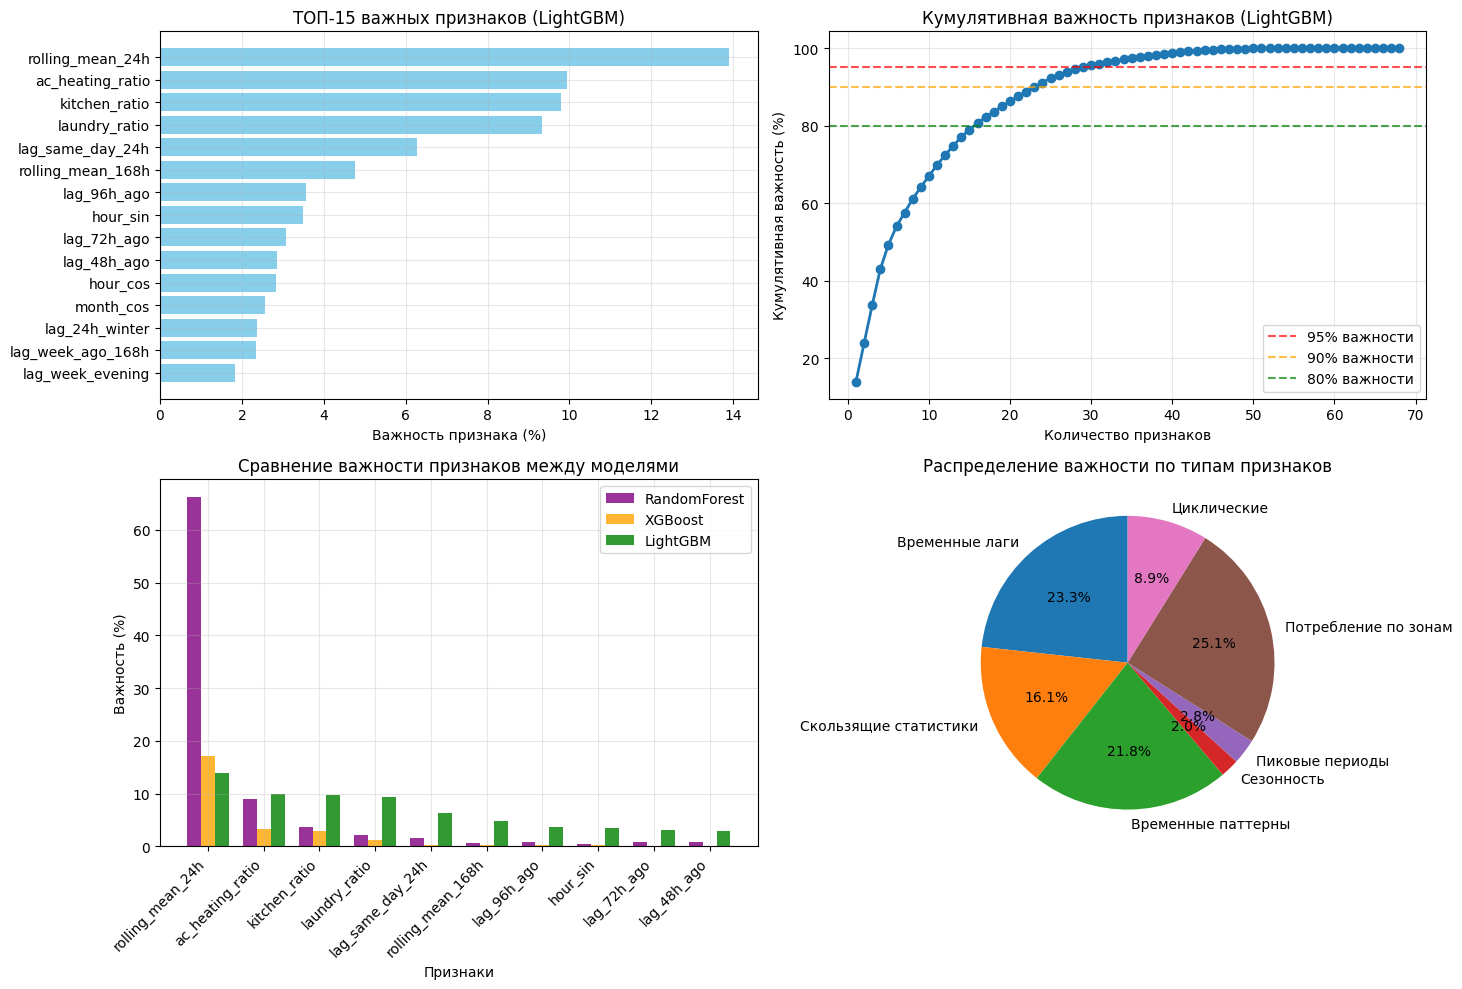


–ê–ù–ê–õ–ò–ó –ö–†–ò–¢–ò–ß–ï–°–ö–ò–• –ü–†–ò–ó–ù–ê–ö–û–í
–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 80% –≤–∞–∂–Ω–æ—Å—Ç–∏: 16
–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 90% –≤–∞–∂–Ω–æ—Å—Ç–∏: 24
–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 95% –≤–∞–∂–Ω–æ—Å—Ç–∏: 29
–í—Å–µ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: 68

–°–∞–º—ã–µ –≤–∞–∂–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (—Ç–æ–ø-16):
   1. rolling_mean_24h          13.90%
   2. ac_heating_ratio          9.93%
   3. kitchen_ratio             9.80%
   4. laundry_ratio             9.33%
   5. lag_same_day_24h          6.27%
   6. rolling_mean_168h         4.77%
   7. lag_96h_ago               3.57%
   8. hour_sin                  3.50%
   9. lag_72h_ago               3.07%
  10. lag_48h_ago               2.87%
  11. hour_cos                  2.83%
  12. month_cos                 2.57%
  13. lag_24h_winter            2.37%
  14. lag_week_ago_168h         2.33%
  15. lag_week_evening          1.83%
  16. lag_24h_weekend           1.73%

–ê–ù–ê–õ–ò–ó –î–û–ú–ò–ù–ò–†–û–í–ê–ù–ò–Ø:
–°–∞–º—ã–π –≤–∞–∂–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫: rolling_mea

In [356]:
# –ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ú–û–î–ï–õ–ï–ô - –í–ê–ñ–ù–û–°–¢–¨ –ü–†–ò–ó–ù–ê–ö–û–í (–ò–°–ü–†–ê–í–õ–ï–ù–ù–ê–Ø –í–ï–†–°–ò–Ø)
print("=" * 60)
print("–ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ú–û–î–ï–õ–ï–ô - –ê–ù–ê–õ–ò–ó –í–ê–ñ–ù–û–°–¢–ò –ü–†–ò–ó–ù–ê–ö–û–í")
print("=" * 60)

# –í–ê–ñ–ù–û: –∏—Å–ø–æ–ª—å–∑—É–µ–º –¢–ï –ñ–ï –ø—Ä–∏–∑–Ω–∞–∫–∏, —á—Ç–æ –∏ –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ –º–æ–¥–µ–ª–µ–π!
model_features = X_train.columns.tolist()
print(f"–ú–æ–¥–µ–ª–∏ –æ–±—É—á–µ–Ω—ã –Ω–∞ {len(model_features)} –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö")

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –≤–∞–∂–Ω–æ—Å—Ç—å—é –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π
feature_importance_df = pd.DataFrame(index=model_features)

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
def normalize_importance(importance_array):
    """–ù–æ—Ä–º–∞–ª–∏–∑—É–µ—Ç –≤–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∫ –¥–∏–∞–ø–∞–∑–æ–Ω—É 0-100%"""
    if np.sum(importance_array) == 0:
        return importance_array
    return (importance_array / np.sum(importance_array)) * 100

# –î–ª—è RandomForest
if hasattr(rf_model, 'feature_importances_'):
    if len(rf_model.feature_importances_) == len(model_features):
        feature_importance_df['RandomForest'] = normalize_importance(rf_model.feature_importances_)

# –î–ª—è XGBoost - –∏—Å–ø–æ–ª—å–∑—É–µ–º gain-based importance
if hasattr(xgb_model, 'get_booster'):
    try:
        xgb_importance = xgb_model.get_booster().get_score(importance_type='gain')
        # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Å–ª–æ–≤–∞—Ä—å –≤ –º–∞—Å—Å–∏–≤ –≤ –ø—Ä–∞–≤–∏–ª—å–Ω–æ–º –ø–æ—Ä—è–¥–∫–µ
        xgb_importance_array = np.array([xgb_importance.get(f, 0) for f in model_features])
        feature_importance_df['XGBoost'] = normalize_importance(xgb_importance_array)
    except:
        # Fallback –∫ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–π –≤–∞–∂–Ω–æ—Å—Ç–∏
        if hasattr(xgb_model, 'feature_importances_'):
            feature_importance_df['XGBoost'] = normalize_importance(xgb_model.feature_importances_)

# –î–ª—è LightGBM - –∏—Å–ø–æ–ª—å–∑—É–µ–º gain-based importance
if hasattr(lgb_model, 'feature_importances_'):
    if len(lgb_model.feature_importances_) == len(model_features):
        feature_importance_df['LightGBM'] = normalize_importance(lgb_model.feature_importances_)

# –ü—Ä–æ–≤–µ—Ä—è–µ–º –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ—Å—Ç—å –¥–∞–Ω–Ω—ã—Ö
print("\n=== –ü–†–û–í–ï–†–ö–ê –ö–û–†–†–ï–ö–¢–ù–û–°–¢–ò –î–ê–ù–ù–´–• ===")
for model in feature_importance_df.columns:
    total_importance = feature_importance_df[model].sum()
    print(f"{model}: —Å—É–º–º–∞ –≤–∞–∂–Ω–æ—Å—Ç–µ–π = {total_importance:.1f}%")
    
    if abs(total_importance - 100) > 1:  # –î–æ–ø—É—Å–∫ 1%
        print(f"‚ö†Ô∏è  {model}: –≤–æ–∑–º–æ–∂–Ω–∞ –æ—à–∏–±–∫–∞ –≤ —Ä–∞—Å—á–µ—Ç–∞—Ö!")

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –º–æ–¥–µ–ª—å –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞
if best_model in feature_importance_df.columns:
    sort_column = best_model
elif 'LightGBM' in feature_importance_df.columns:
    sort_column = 'LightGBM'
elif 'XGBoost' in feature_importance_df.columns:
    sort_column = 'XGBoost'
else:
    sort_column = feature_importance_df.columns[0]

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
feature_importance_df = feature_importance_df.sort_values(sort_column, ascending=False)

print(f"\n–¢–û–ü-15 —Å–∞–º—ã—Ö –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –≤–µ—Ä—Å–∏–∏ {sort_column}:")
print("=" * 50)
for i, (feature, importance) in enumerate(feature_importance_df[sort_column].head(15).items()):
    print(f"{i+1:2d}. {feature:<25} {importance:.2f}%")

# –í–ò–ó–£–ê–õ–ò–ó–ê–¶–ò–Ø –í–ê–ñ–ù–û–°–¢–ò –ü–†–ò–ó–ù–ê–ö–û–í
plt.figure(figsize=(15, 10))

# –ì—Ä–∞—Ñ–∏–∫ 1: –í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
plt.subplot(2, 2, 1)
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features[sort_column], color='skyblue')
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('–í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–∞ (%)')
plt.title(f'–¢–û–ü-15 –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ ({sort_column})')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 2: –ö—É–º—É–ª—è—Ç–∏–≤–Ω–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
plt.subplot(2, 2, 2)
cumulative_importance = np.cumsum(feature_importance_df[sort_column])
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linewidth=2)
plt.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% –≤–∞–∂–Ω–æ—Å—Ç–∏')
plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% –≤–∞–∂–Ω–æ—Å—Ç–∏')
plt.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='80% –≤–∞–∂–Ω–æ—Å—Ç–∏')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
plt.ylabel('–ö—É–º—É–ª—è—Ç–∏–≤–Ω–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å (%)')
plt.title(f'–ö—É–º—É–ª—è—Ç–∏–≤–Ω–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ ({sort_column})')
plt.legend()
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 3: –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π (–¢–û–ü-10 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤)
plt.subplot(2, 2, 3)
top_10_features = feature_importance_df.head(10)
x = np.arange(len(top_10_features))
width = 0.25

available_models = [col for col in ['RandomForest', 'XGBoost', 'LightGBM'] if col in feature_importance_df.columns]

if len(available_models) >= 2:
    colors = ['purple', 'orange', 'green']
    for i, model in enumerate(available_models):
        offset = width * (i - (len(available_models)-1)/2)
        plt.bar(x + offset, top_10_features[model], width, label=model, alpha=0.8, color=colors[i])
    
    plt.xlabel('–ü—Ä–∏–∑–Ω–∞–∫–∏')
    plt.ylabel('–í–∞–∂–Ω–æ—Å—Ç—å (%)')
    plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –º–µ–∂–¥—É –º–æ–¥–µ–ª—è–º–∏')
    plt.xticks(x, top_10_features.index, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, '–ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –¥–∞–Ω–Ω—ã—Ö\n–¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–µ–π', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')

# –ì—Ä–∞—Ñ–∏–∫ 4: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —Ç–∏–ø–∞–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
plt.subplot(2, 2, 4)
top_20_features = feature_importance_df.head(20)

# –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
feature_categories = {
    '–í—Ä–µ–º–µ–Ω–Ω—ã–µ –ª–∞–≥–∏': [f for f in top_20_features.index if 'lag' in f],
    '–°–∫–æ–ª—å–∑—è—â–∏–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏': [f for f in top_20_features.index if 'rolling' in f or 'mean' in f or 'std' in f],
    '–í—Ä–µ–º–µ–Ω–Ω—ã–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã': [f for f in top_20_features.index if 'hour' in f or 'day' in f or 'week' in f or 'month' in f],
    '–°–µ–∑–æ–Ω–Ω–æ—Å—Ç—å': [f for f in top_20_features.index if 'season' in f or 'spring' in f or 'winter' in f or 'summer' in f],
    '–ü–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã': [f for f in top_20_features.index if 'peak' in f or 'night' in f or 'morning' in f or 'evening' in f],
    '–ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –ø–æ –∑–æ–Ω–∞–º': [f for f in top_20_features.index if 'kitchen' in f or 'laundry' in f or 'ac_heating' in f],
    '–¶–∏–∫–ª–∏—á–µ—Å–∫–∏–µ': [f for f in top_20_features.index if 'sin' in f or 'cos' in f],
    '–î—Ä—É–≥–∏–µ': []
}

# –ù–∞—Ö–æ–¥–∏–º "–î—Ä—É–≥–∏–µ"
used_features = set()
for features in feature_categories.values():
    used_features.update(features)
feature_categories['–î—Ä—É–≥–∏–µ'] = [f for f in top_20_features.index if f not in used_features]

# –°—á–∏—Ç–∞–µ–º –≤–∞–∂–Ω–æ—Å—Ç—å –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º
category_importance = {}
for category, features in feature_categories.items():
    if features:
        importance_sum = feature_importance_df.loc[features, sort_column].sum()
        if importance_sum > 0.1:  # –ò–≥–Ω–æ—Ä–∏—Ä—É–µ–º –æ—á–µ–Ω—å –º–∞–ª–µ–Ω—å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è
            category_importance[category] = importance_sum

if category_importance:
    plt.pie(category_importance.values(), labels=category_importance.keys(), autopct='%1.1f%%', startangle=90)
    plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø–æ —Ç–∏–ø–∞–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
else:
    plt.text(0.5, 0.5, '–ù–µ—Ç –¥–∞–Ω–Ω—ã—Ö –¥–ª—è\n–ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è –¥–∏–∞–≥—Ä–∞–º–º—ã', 
            ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# –ê–ù–ê–õ–ò–ó –ö–†–ò–¢–ò–ß–ï–°–ö–ò–• –ü–†–ò–ó–ù–ê–ö–û–í
print("\n" + "=" * 60)
print("–ê–ù–ê–õ–ò–ó –ö–†–ò–¢–ò–ß–ï–°–ö–ò–• –ü–†–ò–ó–ù–ê–ö–û–í")
print("=" * 60)

# –ù–∞—Ö–æ–¥–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è —Ä–∞–∑–Ω—ã—Ö —É—Ä–æ–≤–Ω–µ–π –≤–∞–∂–Ω–æ—Å—Ç–∏
n_features_80 = np.argmax(cumulative_importance >= 80) + 1 if any(cumulative_importance >= 80) else len(cumulative_importance)
n_features_90 = np.argmax(cumulative_importance >= 90) + 1 if any(cumulative_importance >= 90) else len(cumulative_importance)
n_features_95 = np.argmax(cumulative_importance >= 95) + 1 if any(cumulative_importance >= 95) else len(cumulative_importance)

print(f"–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 80% –≤–∞–∂–Ω–æ—Å—Ç–∏: {n_features_80}")
print(f"–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 90% –≤–∞–∂–Ω–æ—Å—Ç–∏: {n_features_90}") 
print(f"–ü—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è 95% –≤–∞–∂–Ω–æ—Å—Ç–∏: {n_features_95}")
print(f"–í—Å–µ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {len(feature_importance_df)}")

print(f"\n–°–∞–º—ã–µ –≤–∞–∂–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (—Ç–æ–ø-{n_features_80}):")
critical_features = feature_importance_df.head(n_features_80).index.tolist()
for i, feature in enumerate(critical_features, 1):
    importance = feature_importance_df.loc[feature, sort_column]
    print(f"  {i:2d}. {feature:<25} {importance:.2f}%")

# –ê–Ω–∞–ª–∏–∑ –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏—è
top_feature_importance = feature_importance_df[sort_column].iloc[0]
print(f"\n–ê–ù–ê–õ–ò–ó –î–û–ú–ò–ù–ò–†–û–í–ê–ù–ò–Ø:")
print(f"–°–∞–º—ã–π –≤–∞–∂–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫: {feature_importance_df.index[0]} ({top_feature_importance:.1f}%)")

if top_feature_importance > 50:
    print("üî¥ –ö–†–ò–¢–ò–ß–ï–°–ö–û–ï –î–û–ú–ò–ù–ò–†–û–í–ê–ù–ò–ï: –û–¥–∏–Ω –ø—Ä–∏–∑–Ω–∞–∫ >50%")
    print("   –†–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è –∏—Å–∫–ª—é—á–∏—Ç—å —ç—Ç–æ—Ç –ø—Ä–∏–∑–Ω–∞–∫ –∏–ª–∏ –æ—Å–ª–∞–±–∏—Ç—å –µ–≥–æ –≤–ª–∏—è–Ω–∏–µ")
elif top_feature_importance > 30:
    print("üü° –£–ú–ï–†–ï–ù–ù–û–ï –î–û–ú–ò–ù–ò–†–û–í–ê–ù–ò–ï: –û–¥–∏–Ω –ø—Ä–∏–∑–Ω–∞–∫ 30-50%")
    print("   –†–∞—Å—Å–º–æ—Ç—Ä–µ—Ç—å –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")
elif top_feature_importance > 20:
    print("üü¢ –ù–û–†–ú–ê: –°–∞–º—ã–π –≤–∞–∂–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫ 20-30%")
else:
    print("‚úÖ –û–¢–õ–ò–ß–ù–û: –°–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤–∞–∂–Ω–æ—Å—Ç–∏")

print(f"\n–ò–ù–¢–ï–†–ü–†–ï–¢–ê–¶–ò–Ø –ó–ê–í–ï–†–®–ï–ù–ê!")


–ê–ù–ê–õ–ò–ó –û–®–ò–ë–û–ö –ü–†–û–ì–ù–û–ó–ò–†–û–í–ê–ù–ò–Ø
–ë–æ–ª—å—à–∏–µ –æ—à–∏–±–∫–∏ (> 0.05 –∫–í—Ç): 34865 (66.88%)

–•–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ –ø–µ—Ä–∏–æ–¥–æ–≤ —Å –±–æ–ª—å—à–∏–º–∏ –æ—à–∏–±–∫–∞–º–∏:
–ß–∞—Å –¥–Ω—è:
hour
0     1481
1     1113
2     1003
3      940
4     1025
5     1057
6     1660
7     1846
8     1561
9     1510
10    1481
11    1465
12    1428
13    1371
14    1220
15    1219
16    1315
17    1300
18    1526
19    1890
20    1956
21    1943
22    1865
23    1690
Name: count, dtype: int64

–î–µ–Ω—å –Ω–µ–¥–µ–ª–∏:
  –ü–Ω: 4651 –æ—à–∏–±–æ–∫
  –í—Ç: 4865 –æ—à–∏–±–æ–∫
  –°—Ä: 4972 –æ—à–∏–±–æ–∫
  –ß—Ç: 4233 –æ—à–∏–±–æ–∫
  –ü—Ç: 4929 –æ—à–∏–±–æ–∫
  –°–±: 5755 –æ—à–∏–±–æ–∫
  –í—Å: 5460 –æ—à–∏–±–æ–∫

–ü–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã:
  –í–µ—á–µ—Ä–Ω–∏–π –ø–∏–∫: 9180 –æ—à–∏–±–æ–∫
  –£—Ç—Ä–µ–Ω–Ω–∏–π –ø–∏–∫: 4917 –æ—à–∏–±–æ–∫
  –ù–æ—á–Ω–æ–µ –≤—Ä–µ–º—è: 6619 –æ—à–∏–±–æ–∫


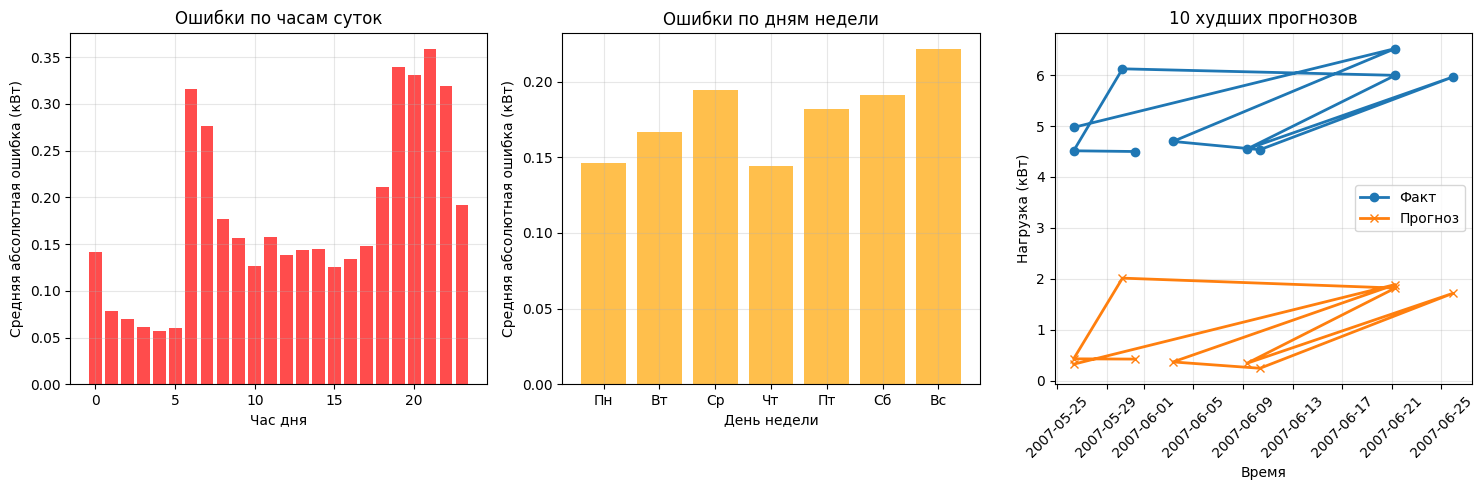

In [357]:
# –ê–ù–ê–õ–ò–ó –û–®–ò–ë–û–ö –ü–†–û–ì–ù–û–ó–ò–†–û–í–ê–ù–ò–Ø
print("\n" + "=" * 60)
print("–ê–ù–ê–õ–ò–ó –û–®–ò–ë–û–ö –ü–†–û–ì–ù–û–ó–ò–†–û–í–ê–ù–ò–Ø")
print("=" * 60)

# –ë–µ—Ä–µ–º –ø—Ä–æ–≥–Ω–æ–∑—ã –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
y_pred_best = results[f'{best_model}']['predictions']  # –¢–µ–ø–µ—Ä—å –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å RandomForest!
errors = y_pred_best - y_test.values

# –°–æ–∑–¥–∞–µ–º Series —Å –æ—à–∏–±–∫–∞–º–∏ –∏ –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º–∏ –∏–Ω–¥–µ–∫—Å–∞–º–∏
errors_series = pd.Series(errors, index=y_test.index)

# –ê–Ω–∞–ª–∏–∑ –±–æ–ª—å—à–∏—Ö –æ—à–∏–±–æ–∫
error_threshold = 0.05  # 50 –í—Ç - –ø–æ—Ä–æ–≥ –¥–ª—è "–±–æ–ª—å—à–æ–π" –æ—à–∏–±–∫–∏
large_errors_mask = np.abs(errors) > error_threshold
large_errors_count = np.sum(large_errors_mask)
large_errors_percentage = (large_errors_count / len(errors)) * 100

print(f"–ë–æ–ª—å—à–∏–µ –æ—à–∏–±–∫–∏ (> {error_threshold} –∫–í—Ç): {large_errors_count} ({large_errors_percentage:.2f}%)")

if large_errors_count > 0:
    # –ê–Ω–∞–ª–∏–∑ –∫–æ–≥–¥–∞ –ø—Ä–æ–∏—Å—Ö–æ–¥—è—Ç –±–æ–ª—å—à–∏–µ –æ—à–∏–±–∫–∏
    large_errors_data = X_test[large_errors_mask]
    
    print("\n–•–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ –ø–µ—Ä–∏–æ–¥–æ–≤ —Å –±–æ–ª—å—à–∏–º–∏ –æ—à–∏–±–∫–∞–º–∏:")
    print("–ß–∞—Å –¥–Ω—è:")
    print(large_errors_data['hour'].value_counts().sort_index())
    
    print("\n–î–µ–Ω—å –Ω–µ–¥–µ–ª–∏:")
    day_names = {0: '–ü–Ω', 1: '–í—Ç', 2: '–°—Ä', 3: '–ß—Ç', 4: '–ü—Ç', 5: '–°–±', 6: '–í—Å'}
    day_counts = large_errors_data['day_of_week'].value_counts().sort_index()
    for day, count in day_counts.items():
        print(f"  {day_names[day]}: {count} –æ—à–∏–±–æ–∫")
    
    print(f"\n–ü–∏–∫–æ–≤—ã–µ –ø–µ—Ä–∏–æ–¥—ã:")
    print(f"  –í–µ—á–µ—Ä–Ω–∏–π –ø–∏–∫: {large_errors_data['is_evening_peak'].sum()} –æ—à–∏–±–æ–∫")
    print(f"  –£—Ç—Ä–µ–Ω–Ω–∏–π –ø–∏–∫: {large_errors_data['is_morning_peak'].sum()} –æ—à–∏–±–æ–∫")
    print(f"  –ù–æ—á–Ω–æ–µ –≤—Ä–µ–º—è: {large_errors_data['is_night'].sum()} –æ—à–∏–±–æ–∫")

# –í–ò–ó–£–ê–õ–ò–ó–ê–¶–ò–Ø –û–®–ò–ë–û–ö
plt.figure(figsize=(15, 5))

# –ì—Ä–∞—Ñ–∏–∫ 1: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—à–∏–±–æ–∫ –ø–æ –≤—Ä–µ–º–µ–Ω–∏ —Å—É—Ç–æ–∫
plt.subplot(1, 3, 1)
# –ò–°–ü–†–ê–í–õ–ï–ù–ò–ï: —É–±–∏—Ä–∞–µ–º ['Global_active_power'] - –µ–≥–æ –Ω–µ—Ç –≤ X_test
hourly_errors = X_test.groupby('hour').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(hourly_errors.index, hourly_errors.values, alpha=0.7, color='red')
plt.xlabel('–ß–∞—Å –¥–Ω—è')
plt.ylabel('–°—Ä–µ–¥–Ω—è—è –∞–±—Å–æ–ª—é—Ç–Ω–∞—è –æ—à–∏–±–∫–∞ (–∫–í—Ç)')
plt.title('–û—à–∏–±–∫–∏ –ø–æ —á–∞—Å–∞–º —Å—É—Ç–æ–∫')
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 2: –û—à–∏–±–∫–∏ –ø–æ –¥–Ω—è–º –Ω–µ–¥–µ–ª–∏  
plt.subplot(1, 3, 2)
# –ò–°–ü–†–ê–í–õ–ï–ù–ò–ï: —É–±–∏—Ä–∞–µ–º ['Global_active_power']
daily_errors = X_test.groupby('day_of_week').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(daily_errors.index, daily_errors.values, alpha=0.7, color='orange')
plt.xlabel('–î–µ–Ω—å –Ω–µ–¥–µ–ª–∏')
plt.ylabel('–°—Ä–µ–¥–Ω—è—è –∞–±—Å–æ–ª—é—Ç–Ω–∞—è –æ—à–∏–±–∫–∞ (–∫–í—Ç)')
plt.title('–û—à–∏–±–∫–∏ –ø–æ –¥–Ω—è–º –Ω–µ–¥–µ–ª–∏')
plt.xticks(range(7), ['–ü–Ω', '–í—Ç', '–°—Ä', '–ß—Ç', '–ü—Ç', '–°–±', '–í—Å'])
plt.grid(True, alpha=0.3)

# –ì—Ä–∞—Ñ–∏–∫ 3: –§–∞–∫—Ç vs –ü—Ä–æ–≥–Ω–æ–∑ –¥–ª—è —Ö—É–¥—à–∏—Ö —Å–ª—É—á–∞–µ–≤
plt.subplot(1, 3, 3)
worst_indices = np.argsort(np.abs(errors))[-10:]  # 10 —Ö—É–¥—à–∏—Ö –ø—Ä–æ–≥–Ω–æ–∑–æ–≤
worst_times = y_test.iloc[worst_indices].index

plt.plot(worst_times, y_test.iloc[worst_indices], 'o-', label='–§–∞–∫—Ç', linewidth=2)
plt.plot(worst_times, y_pred_best[worst_indices], 'x-', label='–ü—Ä–æ–≥–Ω–æ–∑', linewidth=2)
plt.xlabel('–í—Ä–µ–º—è')
plt.ylabel('–ù–∞–≥—Ä—É–∑–∫–∞ (–∫–í—Ç)')
plt.title('10 —Ö—É–¥—à–∏—Ö –ø—Ä–æ–≥–Ω–æ–∑–æ–≤')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [358]:
# –°–û–•–†–ê–ù–ï–ù–ò–ï –¢–û–õ–¨–ö–û –õ–£–ß–®–ï–ô –ú–û–î–ï–õ–ò
print("–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ç–æ–ª—å–∫–æ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏...")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ç–æ–ª—å–∫–æ –ª—É—á—à—É—é –º–æ–¥–µ–ª—å
best_model_name = best_model
best_model_obj = models[best_model_name]

filename = f'models/best_model_{best_model_name.lower()}.pkl'
joblib.dump(best_model_obj, filename)
print(f"‚úÖ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: {best_model_name} -> {filename}")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–µ—Ç—Ä–∏–∫–∏ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è
results_df = pd.DataFrame(results).T
results_df.to_csv('models/all_models_metrics.csv')
print("üìä –ú–µ—Ç—Ä–∏–∫–∏ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ –æ—Ç–¥–µ–ª—å–Ω–æ
best_model_info = {
    'model_name': best_model_name,
    'mae': results[best_model_name]['MAE'],
    'rmse': results[best_model_name]['RMSE'], 
    'r2': results[best_model_name]['R2'],
    'features_count': X_train.shape[1],
    'train_size': X_train.shape[0],
    'test_size': X_test.shape[0],
    'train_period': f"{X_train.index.min()} - {X_train.index.max()}",
    'test_period': f"{X_test.index.min()} - {X_test.index.max()}"
}

with open('models/best_model_info.json', 'w', encoding='utf-8') as f:
    json.dump(best_model_info, f, ensure_ascii=False, indent=2)
print("üìã –ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –æ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –∏–º–µ–Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –±—É–¥—É—â–µ–≥–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
feature_names = X_train.columns.tolist()
with open('models/feature_names.json', 'w', encoding='utf-8') as f:
    json.dump(feature_names, f, ensure_ascii=False, indent=2)
print(f"üîß –°–æ—Ö—Ä–∞–Ω–µ–Ω—ã –∏–º–µ–Ω–∞ {len(feature_names)} –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")

print(f"\nüéØ –ò–¢–û–ì–û–í–´–ô –†–ï–ó–£–õ–¨–¢–ê–¢:")
print(f"   –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: {best_model_name}")
print(f"   MAE: {results[best_model_name]['MAE']:.4f} –∫–í—Ç ({results[best_model_name]['MAE']*1000:.1f} –í—Ç)")
print(f"   R¬≤: {results[best_model_name]['R2']:.4f} ({results[best_model_name]['R2']*100:.2f}%)")
print(f"   –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {X_train.shape[1]}")
print(f"   –†–∞–∑–º–µ—Ä –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏: {X_train.shape[0]:,} –∑–∞–ø–∏—Å–µ–π")
print(f"   –ü–µ—Ä–∏–æ–¥ –æ–±—É—á–µ–Ω–∏—è: {X_train.index.min().strftime('%d.%m.%Y')} - {X_train.index.max().strftime('%d.%m.%Y')}")

–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ç–æ–ª—å–∫–æ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏...
‚úÖ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: LightGBM -> models/best_model_lightgbm.pkl
üìä –ú–µ—Ç—Ä–∏–∫–∏ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è
üìã –ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –æ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞
üîß –°–æ—Ö—Ä–∞–Ω–µ–Ω—ã –∏–º–µ–Ω–∞ 68 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

üéØ –ò–¢–û–ì–û–í–´–ô –†–ï–ó–£–õ–¨–¢–ê–¢:
   –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: LightGBM
   MAE: 0.1783 –∫–í—Ç (178.3 –í—Ç)
   R¬≤: 0.8795 (87.95%)
   –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: 68
   –†–∞–∑–º–µ—Ä –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏: 208,512 –∑–∞–ø–∏—Å–µ–π
   –ü–µ—Ä–∏–æ–¥ –æ–±—É—á–µ–Ω–∏—è: 01.01.2007 - 25.05.2007
